# Проект "Стальная птица" - прогнозирование температуры сплава

## Задача проекта:

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава.

**Наша задача — построить модель, которая будет её предсказывать.**

## Метрика качества решения задачи

Му решаем задачу прогнозирования температуры, это задача регрессии.

Для оценки регресси подходит метрика ```MAE```, среднее значение всех абсолютных ошибок прогнозирования, где ошибкой прогнозирования является разница между фактическим значением и прогнозным значением

MAE должно быть менее ```6.8```

Качество лучшей модели мы будем проверять на тестовой выборке.

## Рекомендуемые модели

Для решения задачи рекомендуется рассмотреть классы моделей:

- решающее дерево или случайный лес,

- бустинги,

- нейронные сети.

## Описание процесса

Заказчик хочет использовать разработанную модель для имитации технологического процесса. Нужно изучить его, прежде чем генерировать новые признаки.

1. Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн.

2. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом.

3. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены на крышке ковша.

4. Сначала происходит десульфурация — из стали выводят серу и корректируют её химический состав добавлением примесей.

5. Затем сталь легируют — добавляют в неё куски сплава из бункера для сыпучих материалов или порошковую проволоку через специальный трайб-аппарат.

6. Прежде чем в первый раз ввести легирующие добавки, специалисты производят химический анализ стали и измеряют её температуру.

7. Потом температуру на несколько минут повышают, уже после этого добавляют легирующие материалы и продувают сталь инертным газом, чтобы перемешать, а затем снова проводят измерения.

8. Такой цикл повторяется до тех пор, пока не будут достигнуты нужный химический состав стали и оптимальная температура плавки.

9. Дальше расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

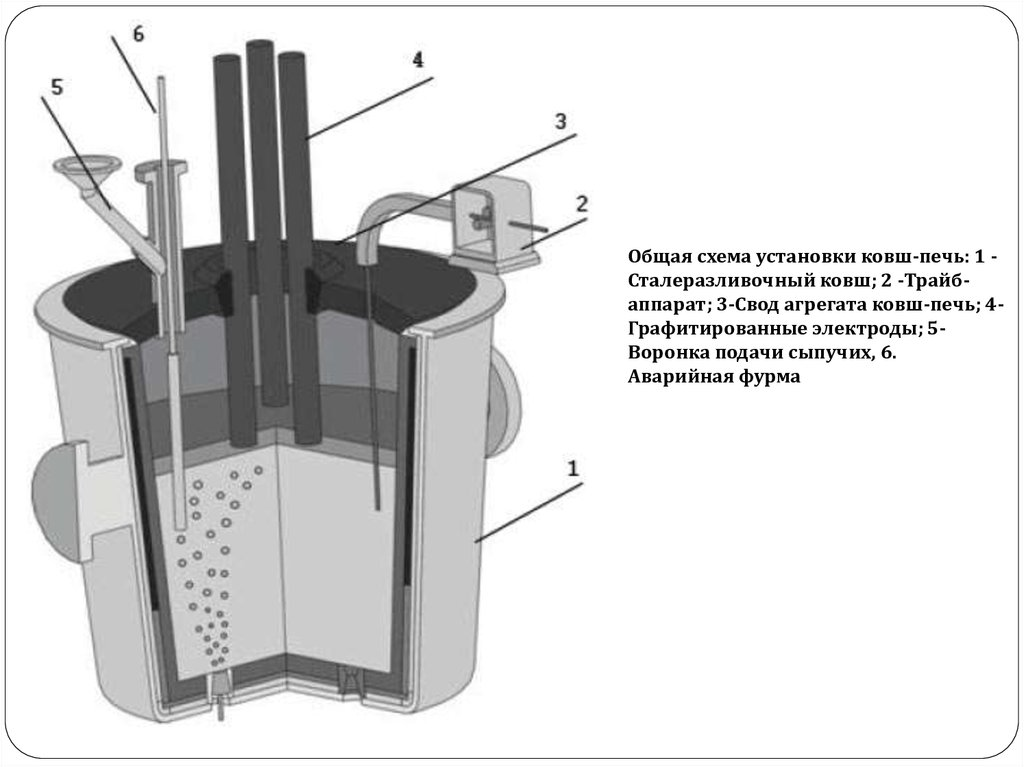

## Описание данных:

Данные хранятся в Sqlite  — СУБД, в которой база данных представлена одним файлом. Она состоит из нескольких таблиц:

- ```steel.data_arc``` — данные об электродах;                 
- ```steel.data_bulk``` — данные об объёме сыпучих материалов;                 
- ```steel.data_bulk_time``` — данные о времени подачи сыпучих материалов;                 
- ```steel.data_gas``` — данные о продувке сплава газом;                 
- ```steel.data_temp``` — данные об измерениях температуры;                 
- ```steel.data_wire``` — данные об объёме проволочных материалов;                 
- ```steel.data_wire_time``` — данные о времени подачи проволочных материалов.                 


Во всех файлах столбец ```key``` содержит номер партии. В таблицах может быть несколько строк с одинаковым значением ```key```: они соответствуют разным итерациям обработки.

## Подготовка среды проекта

### Импорт библиотек

In [72]:
!pip install phik -q
!pip install catboost -q
!pip install optuna -q
!pip install keras_tuner -q

In [73]:
import os
import numpy as np
import pandas as pd
import numbers

from sqlalchemy import create_engine

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

from scipy.stats import jarque_bera
import phik

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import sklearn.model_selection as ms
import math
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
import sklearn.metrics as sklm
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import KFold

from catboost import CatBoostRegressor, Pool

import optuna

import tensorflow as tf
from tensorflow import keras
from keras import layers
import keras_tuner

import warnings
import datetime as dt
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor
import multiprocessing

warnings.filterwarnings('ignore')

### Установка констант

In [224]:
RND_ST = 160924
pd.set_option('display.max_columns', 25)
FMDT = '%Y-%m-%d:%H:%M:%S' #формат для данных datetime
FMT = '%H:%M:%S' #формат для данных тип time

### Вспомогательные функции

In [75]:
def get_plot(data,title, ylabel, xlabel, plot='h', bins=15):
  if plot == 'h':
    # Установка стиля
    sns.set(style='whitegrid')

    # Настройка параметров стиля и цветовой палитры
    plt.figure(figsize=(10, 6))  # Увеличение размера фигуры
    palette = sns.color_palette('YlOrRd', 8)  # Теплая цветовая палитра

    # Построение диаграммы
    ax = data.plot(kind='hist', bins=bins, color=palette[3], edgecolor='black')

    # Добавление заголовков и подписей
    ax.set_title(title, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_xlabel(xlabel, fontsize=12)

    # Показываем диаграмму
    plt.tight_layout()
    plt.show()
  elif plot == 'p':
    plt.figure(figsize=(10, 7))  # Увеличиваем размер диаграммы

    # Получим теплые цвета из палитры 'autumn'
    colors = plt.cm.autumn(mcolors.Normalize()(range(len(data_bulk_time.columns))))

    # Построение диаграммы
    ax = data.plot(
        kind='bar',
        color=colors,  # Устанавливаем теплые цвета
        edgecolor='black'  # Добавляем грани к столбцам
    )

    # Добавление горизонтальной линии
    ax.axhline(y=0.1, color='r', linestyle='-', linewidth=1)

    # Настройка заголовков и меток
    ax.set_title(title, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.tick_params(axis='x', rotation=45)  # Поворот меток на оси X для лучшей читаемости

    plt.tight_layout()  # Подгоняем layout для предотвращения наложения текста
    plt.show()

In [76]:
def melt_time_and_values(df_values, df_time):
    # Соединим датафреймы значений и времени
    df_joined = df_values.join(df_time, how='inner', lsuffix='', rsuffix='_time')

    # Соберем статистику использования материалов
    df_stat = (~df_time.isnull()).mean().sort_values(ascending=False)

    # Выпишем только те материалы, которые используются в более чем 10% партий
    include_names = df_stat[df_stat >= 0.1].index[1:]

    # Создадим пустой EAV-датафрейм
    df_eav = pd.DataFrame()

    # Для каждого Bulk выполним процедуру "unpivot" и добавим результаты в общую таблицу df_eav
    for name in include_names:
        current_bulk = df_joined[['key', str(name), str(name) + '_time']] \
            .melt(id_vars=['key', str(name) + '_time'], value_vars=[str(name)]).dropna()
        current_bulk.columns = ['key', 'datetime', 'variable', 'value']

        df_eav = pd.concat([df_eav, current_bulk])

    # Приведем дату к дате
    df_eav['datetime'] = pd.to_datetime(df_eav['datetime'])

    # Вернем итоговый датафрейм
    return df_eav

### Настройка подключения к БД

In [77]:
# загрузка базы данных
!wget -q https://code.s3.yandex.net/data-scientist/ds-plus-final.db

In [78]:
path_to_db = '/content/ds-plus-final.db'
engine = create_engine(f'sqlite:///{path_to_db}', echo=False)

### Выводы
- загрузили библиотеки
- установили константы
- вспомогательные функции для построения графиков
- Настроили подключение к базе данных

## Исследовательский анализ данных

### Обзор таблиц

Получим ответы на вопросы:

- Все ли таблицы содержат данные.                        
- Соответствует ли количество таблиц условию задачи.


Определим функцию для упрощенного доступа к базе данных

In [79]:
def showsql(query, return_df=True):
  try:
    task = pd.read_sql_query(query, con=engine)
    if return_df:
      return task
    else:
      display(task)
  except Exception as e:
    print(f'Произошла ошибка при выполнении запроса: {e}')

In [80]:
query_table_names = '''
SELECT name
FROM sqlite_master
WHERE type='table';
'''
tables = showsql(query_table_names, return_df=True)

In [81]:
tables

,name
0,data_arc
1,data_bulk
2,data_bulk_time
3,data_wire_time
4,contract
5,personal
6,phone
7,internet
8,data_gas
9,data_temp


In [82]:
for table in tables['name']:
    print(f"Статистика таблицы {table}:")
    print('-'*50)
    print(showsql(f'PRAGMA table_info({table})'))
    print()
    print('Количество строк в таблице: ',
        showsql(f'SELECT COUNT(*) AS C FROM {table}').iloc[0,0])
    print('='*50)
    print()

Статистика таблицы data_arc:
--------------------------------------------------
   cid                  name     type  notnull dflt_value  pk
0    0                   key  INTEGER        0       None   0
1    1  Начало нагрева дугой     TEXT        0       None   0
2    2   Конец нагрева дугой     TEXT        0       None   0
3    3     Активная мощность   double        0       None   0
4    4   Реактивная мощность   double        0       None   0

Количество строк в таблице:  14876

Статистика таблицы data_bulk:
--------------------------------------------------
    cid     name     type  notnull dflt_value  pk
0     0      key  INTEGER        0       None   0
1     1   Bulk 1   double        0       None   0
2     2   Bulk 2   double        0       None   0
3     3   Bulk 3   double        0       None   0
4     4   Bulk 4   double        0       None   0
5     5   Bulk 5     TEXT        0       None   0
6     6   Bulk 6     TEXT        0       None   0
7     7   Bulk 7     TEXT     

In [83]:
showsql('SELECT COUNT(*) AS С FROM personal').iloc[0,0]

7043

### Вывод по обзору таблиц

- мы написали функцию выполнения запроса к базе данных и сохранении запроса в датафрейм
- мы сделали запрос к sqlite_master для получения имён всех таблиц и сравнили результат с условием задачи. На основе этого мы смогли сделать вывод, что в базе таблиц больше чем в условии задачи, но при этом все таблицы из условия задачи в базе имеются
- мы запросили table_info к каждой таблице из базы даных и получили информацию о её полях. Полученный результат выведен в проект.
- мы запросили количество строк для каждой таблицы. На основе полученных данных мы делаем вывод о том, что все таблицы содержат данные.

### Кросс анализ колонки KEY

In [84]:
tables_true = ['data_arc', 'data_bulk',
               'data_bulk_time', 'data_gas', 'data_temp',
               'data_wire',
               'data_wire_time']

In [85]:
counts = []
for table in tables_true:
  counts.append(showsql(f'SELECT COUNT(DISTINCT(key)) AS {table}_key FROM {table}').iloc[0,0])
unique_key_count = pd.DataFrame({'table':tables_true,
                                 'unique_counts': counts})

In [86]:
query_unique_key_cross = '''
WITH
ark AS (SELECT DISTINCT(key) AS arc_key
        FROM data_arc),
bulk AS (SELECT DISTINCT(key) AS bulk_key
         FROM data_bulk),
bulk_time AS (SELECT DISTINCT(key) AS bulk_time_key
              FROM data_bulk_time),
gas AS (SELECT DISTINCT(key) AS gas_key
        FROM data_gas),
temp AS (SELECT DISTINCT(key) AS temp_key
         FROM data_temp),
wire AS (SELECT DISTINCT(key) AS wire_key
         FROM data_wire),
wire_time AS (SELECT DISTINCT(key) AS wire_time_key
              FROM data_wire_time)

SELECT COUNT(arc_key) AS arc_cross,
       COUNT(bulk_key) AS bulk_cross,
       COUNT(bulk_time_key) AS bulk_time_cross,
       COUNT(gas_key) AS gas_cross,
       COUNT(temp_key) AS temp_cross,
       COUNT(wire_key) AS wire_cross,
       COUNT(wire_time_key) AS wire_time_cross
FROM ark AS arc
INNER JOIN bulk AS bulk ON arc.arc_key=bulk.bulk_key
INNER JOIN bulk_time AS bulk_time ON bulk_time.bulk_time_key=arc.arc_key
INNER JOIN gas AS gas ON gas.gas_key=arc.arc_key
INNER JOIN temp AS temp ON temp.temp_key=arc.arc_key
INNER JOIN wire AS wire ON wire.wire_key=arc.arc_key
INNER JOIN wire_time AS wire_time ON wire_time.wire_time_key=arc.arc_key
'''

showsql(query_unique_key_cross, False)

,arc_cross,bulk_cross,bulk_time_cross,gas_cross,temp_cross,wire_cross,wire_time_cross
0,3022,3022,3022,3022,3022,3022,3022


In [87]:
unique_key_count

,table,unique_counts
0,data_arc,3214
1,data_bulk,3129
2,data_bulk_time,3129
3,data_gas,3239
4,data_temp,3216
5,data_wire,3081
6,data_wire_time,3081


В каждой таблице разное количество уникалньных значений в поле key. Пересечений по ключам 3022 во всех таблицах. Мы считаем, что все расчеты и аналитику стоит происзодить на данных для которых есть ключ во всех таблицах.

## Исследовательский анализ и предобработка данных

### Загрузим все таблицы

In [88]:
data_arc = showsql(f'SELECT * FROM data_arc')
data_bulk = showsql(f'SELECT * FROM data_bulk')
data_bulk_time = showsql(f'SELECT * FROM data_bulk_time')
data_gas = showsql(f'SELECT * FROM data_gas')
data_temp = showsql(f'SELECT * FROM data_temp')
data_wire = showsql(f'SELECT * FROM data_wire')
data_wire_time = showsql(f'SELECT * FROM data_wire_time')

### Исследование и первичная обработка данных

#### data_arc данные об электродах;

In [89]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [90]:
# наименование колонок нужно привести к стандарту
data_arc.columns = ['key', 'arc_heating_start_dttm', 'arc_heating_end_dttm', 'active_power', 'reactive_power']

In [91]:
# время и дату нужно привести к пандоновскому типу данных
data_arc['arc_heating_start_dttm'] = pd.to_datetime(data_arc['arc_heating_start_dttm'])
data_arc['arc_heating_end_dttm'] = pd.to_datetime(data_arc['arc_heating_end_dttm'])

In [92]:
data_arc.sample(5)

,key,arc_heating_start_dttm,arc_heating_end_dttm,active_power,reactive_power
1091,235,2019-05-12 14:41:23,2019-05-12 14:43:42,1.068810,0.836671
8619,1877,2019-07-12 02:32:27,2019-07-12 02:34:59,0.565870,0.365653
11703,2552,2019-08-12 10:14:44,2019-08-12 10:18:27,0.832152,0.563537
2782,604,2019-05-26 08:30:54,2019-05-26 08:35:39,0.378911,0.261880
11944,2597,2019-08-14 08:55:48,2019-08-14 08:57:46,0.352135,0.285767


In [93]:
data_arc.isna().sum()

,0
key,0
arc_heating_start_dttm,0
arc_heating_end_dttm,0
active_power,0
reactive_power,0


Пропусков нет.

In [94]:
# проверим статистику значений в полях
data_arc.describe()

,key,arc_heating_start_dttm,arc_heating_end_dttm,active_power,reactive_power
count,14876.000000,14876,14876,14876.000000,14876.000000
mean,1615.220422,2019-07-05 12:25:51.921081088,2019-07-05 12:28:43.592027392,0.662752,0.438986
min,1.000000,2019-05-03 11:02:14,2019-05-03 11:06:02,0.223120,-715.479924
25%,806.000000,2019-06-03 23:18:23.249999872,2019-06-03 23:21:35,0.467115,0.337175
50%,1617.000000,2019-07-03 01:31:26.500000,2019-07-03 01:35:13,0.599587,0.441639
75%,2429.000000,2019-08-07 22:52:20.750000128,2019-08-07 22:56:47,0.830070,0.608201
max,3241.000000,2019-09-06 17:24:54,2019-09-06 17:26:15,1.463773,1.270284
std,934.571502,NaN,NaN,0.258885,5.873485


Согласно максимальным и минимальным значениям признака arc_heating_start_dttm, у нас данные за 4 месяца.

Также признак reactive_power имеет станадртное отклонение в разы больше чем у active_power, а все остальне метрики (медина, средние, 25%, 50%, 75%) отличаются не в разы. Возможно в данных есть выбросы.

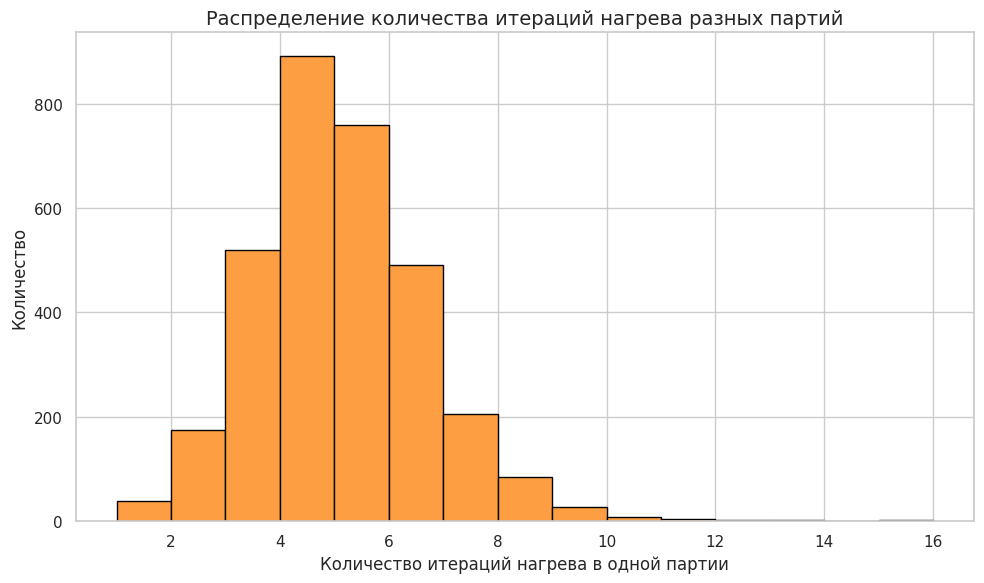

In [95]:
get_plot(data=data_arc.groupby('key')['active_power'].count(),
         bins=15,
         title='Распределение количества итераций нагрева разных партий',
         ylabel='Количество',
         xlabel='Количество итераций нагрева в одной партии')

ПОсмотрим на гистаграму мощности на грева

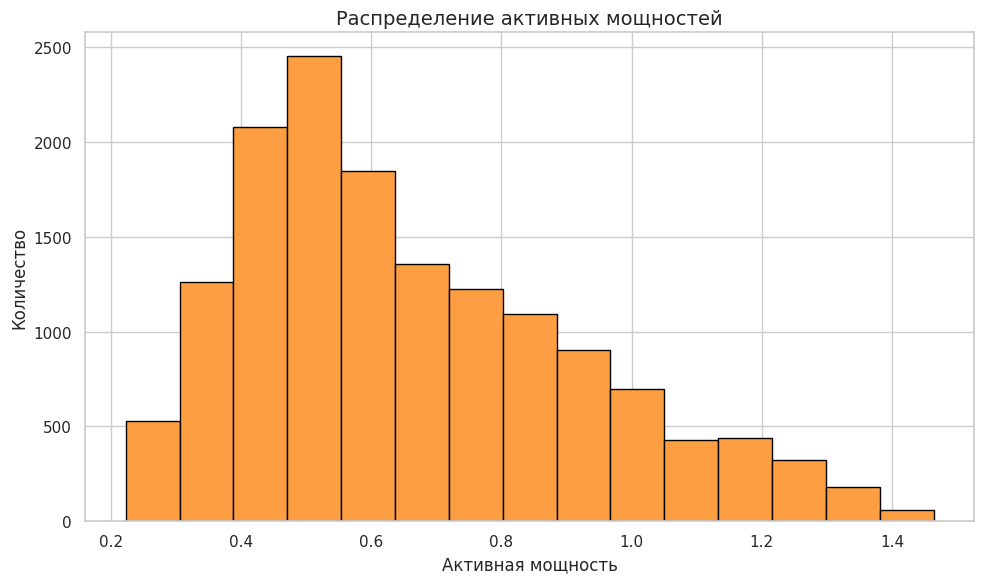

In [96]:
get_plot(data=data_arc['active_power'],
         bins=15,
         title='Распределение активных мощностей',
         ylabel='Количество',
         xlabel='Активная мощность')

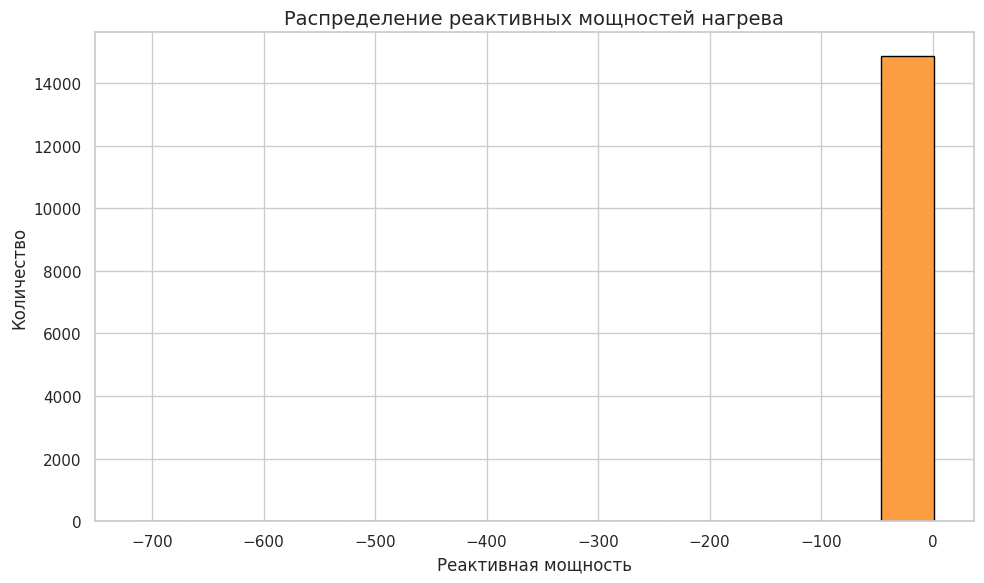

In [97]:
get_plot(data=data_arc['reactive_power'],
         bins=15,
         title='Распределение реактивных мощностей нагрева',
         ylabel='Количество',
         xlabel='Реактивная мощность')

Распределение реактивных мощностей говорит о возможном выбросе.
Посмотрим на топ 10 самых низких значений.

In [98]:
data_arc.sort_values(by=['reactive_power']).head(10)

,key,arc_heating_start_dttm,arc_heating_end_dttm,active_power,reactive_power
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924
709,152,2019-05-09 11:26:58,2019-05-09 11:29:41,0.228852,0.153777
3290,711,2019-05-31 07:16:01,2019-05-31 07:20:05,0.242989,0.153921
11794,2567,2019-08-13 05:51:16,2019-08-13 05:52:22,0.288314,0.155221
6130,1336,2019-06-22 15:46:26,2019-06-22 15:47:50,0.244191,0.156525
9014,1954,2019-07-21 06:26:02,2019-07-21 06:29:01,0.235934,0.157519
8749,1903,2019-07-18 10:56:22,2019-07-18 11:01:39,0.276665,0.157713
5754,1251,2019-06-19 19:36:45,2019-06-19 19:37:59,0.268605,0.161928
6576,1431,2019-06-26 05:00:07,2019-06-26 05:02:17,0.258852,0.162410
11239,2449,2019-08-08 17:53:06,2019-08-08 17:54:59,0.252066,0.163216


In [99]:
data_arc = data_arc[(data_arc['reactive_power']>= 0.153777)].replace()

In [100]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14875 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   key                     14875 non-null  int64         
 1   arc_heating_start_dttm  14875 non-null  datetime64[ns]
 2   arc_heating_end_dttm    14875 non-null  datetime64[ns]
 3   active_power            14875 non-null  float64       
 4   reactive_power          14875 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 697.3 KB


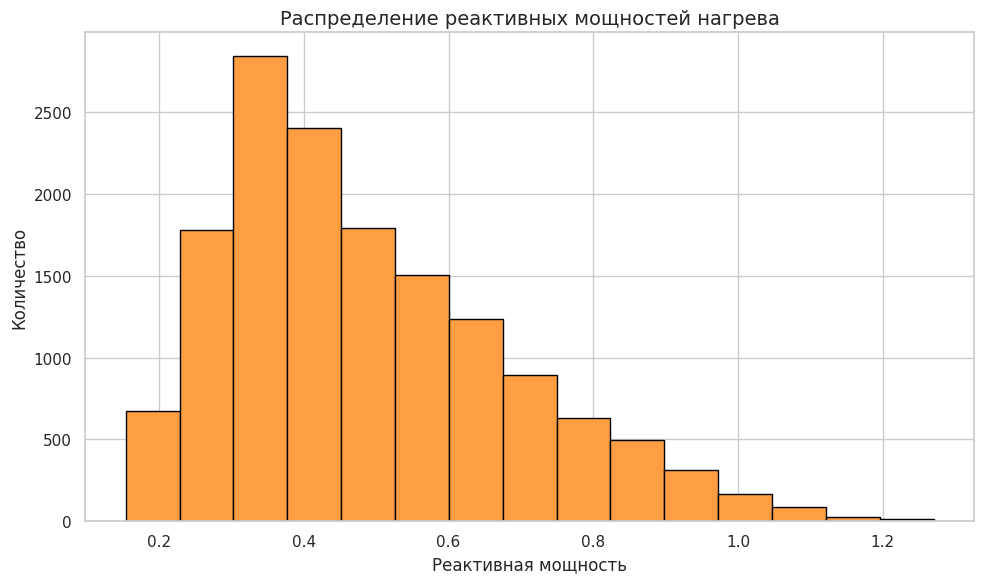

In [101]:
get_plot(data=data_arc['reactive_power'],
         bins=15,
         title='Распределение реактивных мощностей нагрева',
         ylabel='Количество',
         xlabel='Реактивная мощность')

Выбросов больше нет.

#### data_bulk данные об объёме сыпучих материалов. И data_bulk_time данные о времени подачи сыпучих материалов;

Рассмотрим их вместе

In [102]:
data_bulk.head(5)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,None,None,None,None,None,None,None,206.0,None,150.0,154.0
1,2,NaN,NaN,NaN,73.0,None,None,None,None,None,None,None,206.0,None,149.0,154.0
2,3,NaN,NaN,NaN,34.0,None,None,None,None,None,None,None,205.0,None,152.0,153.0
3,4,NaN,NaN,NaN,81.0,None,None,None,None,None,None,None,207.0,None,153.0,154.0
4,5,NaN,NaN,NaN,78.0,None,None,None,None,None,None,None,203.0,None,151.0,152.0


In [103]:
data_bulk_time.head(5)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,None,None,None,2019-05-03 11:28:48,None,None,None,None,None,None,None,2019-05-03 11:24:31,None,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,None,None,None,2019-05-03 11:36:50,None,None,None,None,None,None,None,2019-05-03 11:53:30,None,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,None,None,None,2019-05-03 12:32:39,None,None,None,None,None,None,None,2019-05-03 12:27:13,None,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,None,None,None,2019-05-03 12:43:22,None,None,None,None,None,None,None,2019-05-03 12:58:00,None,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,None,None,None,2019-05-03 13:30:47,None,None,None,None,None,None,None,2019-05-03 13:30:47,None,2019-05-03 13:34:12,2019-05-03 13:30:47


Если судить по первым записям пропуски означают, что сыпучие материалы этого типа в партию не добавлялись.

data_bulk описывает объём подаваемого материала. А data_bulk_time время.

In [104]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     object 
 6   Bulk 6   576 non-null    object 
 7   Bulk 7   25 non-null     object 
 8   Bulk 8   1 non-null      object 
 9   Bulk 9   19 non-null     object 
 10  Bulk 10  176 non-null    object 
 11  Bulk 11  177 non-null    object 
 12  Bulk 12  2450 non-null   object 
 13  Bulk 13  18 non-null     object 
 14  Bulk 14  2806 non-null   object 
 15  Bulk 15  2248 non-null   object 
dtypes: float64(4), int64(1), object(11)
memory usage: 391.2+ KB


In [105]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [106]:
nan_count_df = pd.DataFrame()
nan_count_df['vol'] = data_bulk.isna().sum()
nan_count_df['time'] = data_bulk_time.isna().sum()
nan_count_df

,vol,time
key,0,0
Bulk 1,2877,2877
Bulk 2,3107,3107
Bulk 3,1831,1831
Bulk 4,2115,2115
Bulk 5,3052,3052
Bulk 6,2553,2553
Bulk 7,3104,3104
Bulk 8,3128,3128
Bulk 9,3110,3110


Совпадение количества пропускорв говорит о том, что некоторые сыпучие материалы в партии не использовались. В тоже время мы можем предположить, что всегда при указании объёма сыпучего материала указывается время его добавления без пропусков.

Рассмотрим распределение количеств использования разных сыпучих материалв.

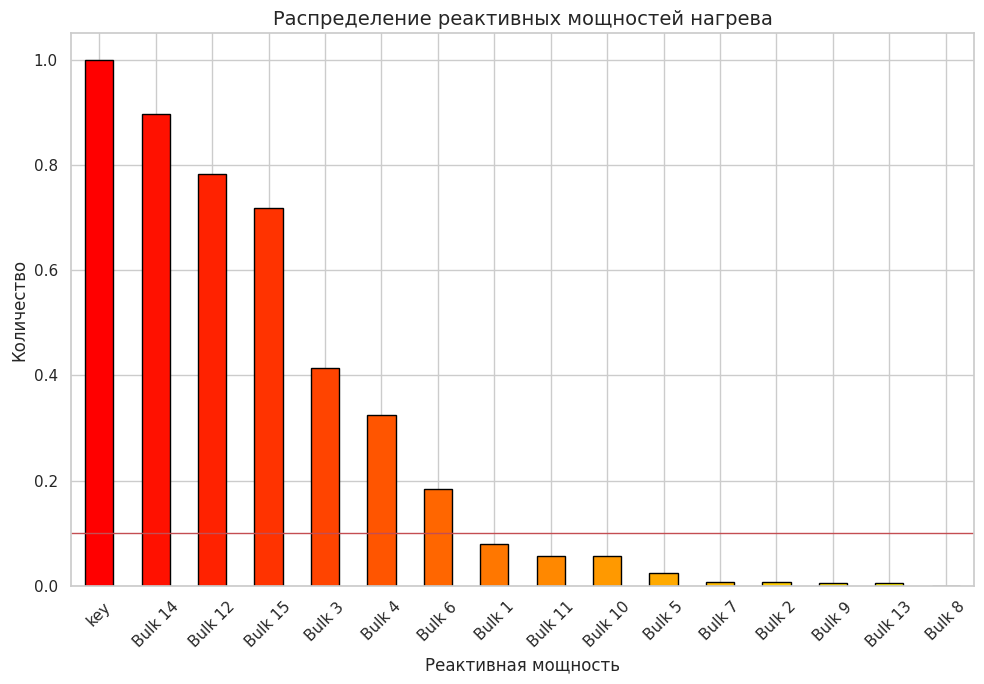

In [107]:
get_plot(data=(~data_bulk_time.isnull()).mean().sort_values(ascending=False),
         plot = 'p',
         title='Распределение реактивных мощностей нагрева',
         ylabel='Количество',
         xlabel='Реактивная мощность')

Из графика видно материалы Bulk 1, 11, 10, 5, 7, 2, 9, 13,8 используются реже всего. И менее чем в 10% партий. Использование этих материало в качесве признаков для предсказания может негативно сказаться на качестве модели. Их следует исключить из дальнейшей работы.

Выпорлним предобработку данных в описанных выше двух таблицах.

- Обединим объём и время добавления материала с идентефикатором материала и номером партии.
- Удалим малоиспользуемые материалы
- Приведем дату к типу данных дата pandas

In [108]:
data_bulk_eav = melt_time_and_values(data_bulk, data_bulk_time)
data_bulk_eav

,key,datetime,variable,value
0,1,2019-05-03 11:14:50,Bulk 14,150.0
1,2,2019-05-03 11:48:37,Bulk 14,149.0
2,3,2019-05-03 12:21:01,Bulk 14,152.0
3,4,2019-05-03 12:51:11,Bulk 14,153.0
4,5,2019-05-03 13:34:12,Bulk 14,151.0
...,...,...,...,...
3111,3224,2019-09-06 02:22:05,Bulk 6,36.0
3112,3225,2019-09-06 04:00:31,Bulk 6,162.0
3113,3226,2019-09-06 05:07:45,Bulk 6,96.0
3126,3239,2019-09-06 15:06:00,Bulk 6,114.0


In [109]:
data_bulk_eav.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10392 entries, 0 to 3127
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   key       10392 non-null  int64         
 1   datetime  10392 non-null  datetime64[ns]
 2   variable  10392 non-null  object        
 3   value     10392 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 405.9+ KB


Таким образом мы получили Entity-Attribute-Value структуру данных о подаче сыпучих материалов, которая не содержит пропусков и избавлена от малоиспользуемых материалов.

In [110]:
# проверим, осталось ли исходным распределение данных
data_bulk_eav.groupby('variable')['value'].count().sort_values(ascending = False)

,value
variable,
Bulk 14,2806
Bulk 12,2450
Bulk 15,2248
Bulk 3,1298
Bulk 4,1014
Bulk 6,576


In [111]:
(~data_bulk_time.drop(['key'], axis = 1).isnull()).sum().sort_values(ascending=False)

,0
Bulk 14,2806
Bulk 12,2450
Bulk 15,2248
Bulk 3,1298
Bulk 4,1014
Bulk 6,576
Bulk 1,252
Bulk 11,177
Bulk 10,176
Bulk 5,77


Всё корректно, мы ничего не потеряли.

#### data_gas данные о продувке сплава газом;

In [112]:
data_gas.sample(10)

,key,Газ 1
343,346,30.768867
3154,3157,11.841368
1650,1653,12.381865
1220,1223,9.712125
774,777,7.682889
3198,3201,8.264568
2314,2317,10.286562
1353,1356,6.192562
244,246,4.328318
2501,2504,9.362822


In [113]:
data_gas.columns = ['key', 'gas']

In [114]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [115]:
data_gas.describe()

,key,gas
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


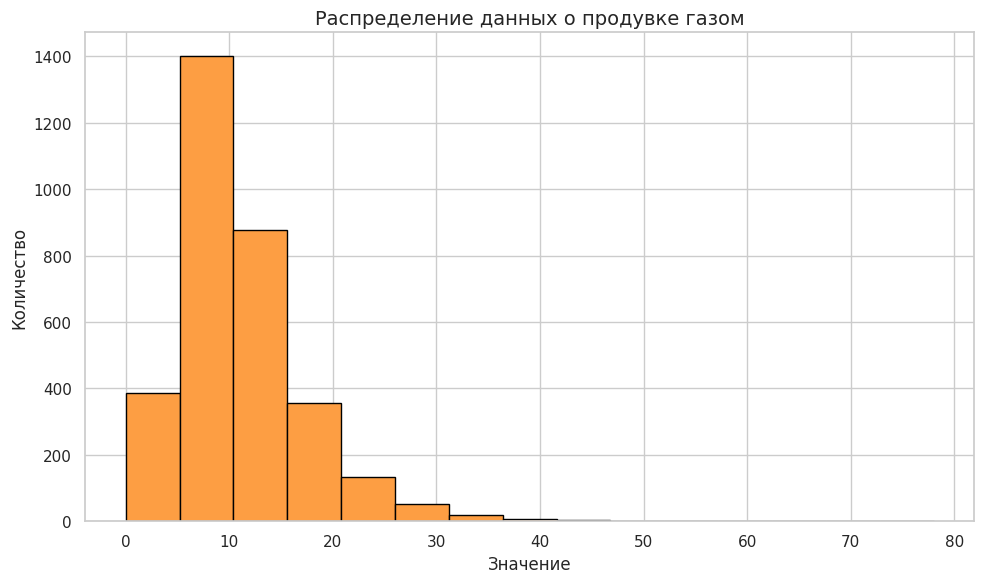

In [116]:
get_plot(data=data_gas['gas'],
         title='Распределение данных о продувке газом',
         ylabel='Количество',
         xlabel='Значение')

In [117]:
data_gas['key'].unique().shape

(3239,)

Данные о продувке газом не содержат привыязки ко времени.
Судя по тому, что количество записей уникальным значением key равно количеству всех записей, можем сделать вывод о том, что продувка газом совершалась один раз в партии в неопределенный момент времени, указанным объёмом газа.

Наиболее популярный объём газа в прартии от 9 до 10 единиц.

#### steel.data_wire данные об объёме проволочных материалов и steel.data_wire_time данные о времени подачи проволочных материалов изучим в связке.

In [118]:
data_wire.head(10)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,None,None,None,None,None,None,None,None
1,2,96.052315,None,None,None,None,None,None,None,None
2,3,91.160157,None,None,None,None,None,None,None,None
3,4,89.063515,None,None,None,None,None,None,None,None
4,5,89.238236,9.11456,None,None,None,None,None,None,None
5,6,99.109917,9.11456,None,None,None,None,None,None,None
6,7,98.061600,None,None,None,None,None,None,None,None
7,8,155.282394,None,None,None,None,None,None,None,None
8,9,113.393279,9.143681,None,None,None,None,None,None,None
9,10,81.244796,12.376,None,None,None,None,None,None,None


In [119]:
data_wire_time.head(10)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,None,None,None,None,None,None,None,None
1,2,2019-05-03 11:36:50,None,None,None,None,None,None,None,None
2,3,2019-05-03 12:11:46,None,None,None,None,None,None,None,None
3,4,2019-05-03 12:43:22,None,None,None,None,None,None,None,None
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,None,None,None,None,None,None,None
5,6,2019-05-03 13:57:27,2019-05-03 13:48:52,None,None,None,None,None,None,None
6,7,2019-05-03 14:18:58,None,None,None,None,None,None,None,None
7,8,2019-05-03 15:01:30,None,None,None,None,None,None,None,None
8,9,2019-05-03 15:45:44,2019-05-03 15:39:37,None,None,None,None,None,None,None
9,10,2019-05-03 16:27:00,2019-05-03 16:22:36,None,None,None,None,None,None,None


In [120]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   object 
 3   Wire 3  63 non-null     object 
 4   Wire 4  14 non-null     object 
 5   Wire 5  1 non-null      object 
 6   Wire 6  73 non-null     object 
 7   Wire 7  11 non-null     object 
 8   Wire 8  19 non-null     object 
 9   Wire 9  29 non-null     object 
dtypes: float64(1), int64(1), object(8)
memory usage: 240.8+ KB


In [121]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


Структура данных об использовании проволочных материалов очень похожа на данные о сыпучих материалов. Выполним их предобработку схожим образом.

Найдем частоту использования разных проволочных материалов

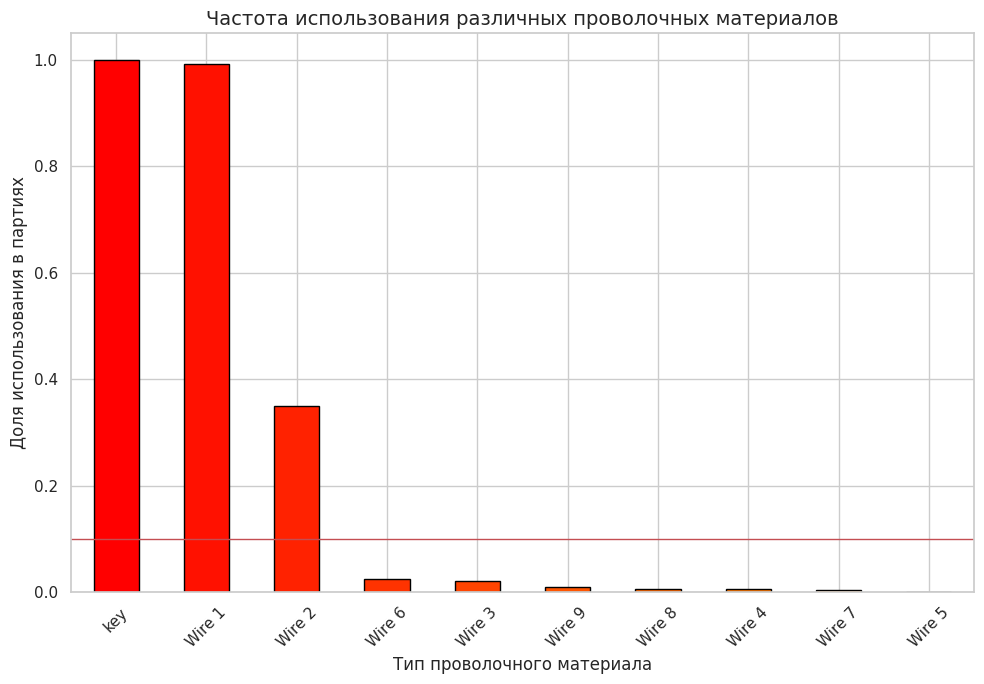

In [122]:
get_plot(data=(~data_wire_time.isnull()).mean().sort_values(ascending=False),
         plot='p',
         title='Частота использования различных проволочных материалов',
         xlabel='Тип проволочного материала',
         ylabel='Доля использования в партиях')

Из графика видим, что есть проволочные материалы, который используются редко. Мы считаем, что от них необходимо избавиться для повышения качества модели.

In [123]:
data_wire_eav = melt_time_and_values(data_wire, data_wire_time)
data_wire_eav

,key,datetime,variable,value
0,1,2019-05-03 11:06:19,Wire 1,60.059998
1,2,2019-05-03 11:36:50,Wire 1,96.052315
2,3,2019-05-03 12:11:46,Wire 1,91.160157
3,4,2019-05-03 12:43:22,Wire 1,89.063515
4,5,2019-05-03 13:20:44,Wire 1,89.238236
...,...,...,...,...
3048,3209,2019-09-05 12:46:02,Wire 2,14.14504
3052,3213,2019-09-05 16:45:51,Wire 2,10.07344
3057,3218,2019-09-05 20:40:37,Wire 2,10.07344
3062,3223,2019-09-06 01:38:22,Wire 2,21.202478


Таким образом мы получили Entity-Attribute-Value структуру данных о подаче проволочных материалов, которая не содержит пропусков и избавлена от малоиспользуемых материалов.

#### steel.data_temp данные об измерениях температуры. Целевые данные.

In [124]:
data_temp.sample(10)

,key,Время замера,Температура
17153,3067,2019-08-31 19:22:58,None
4336,775,2019-06-02 19:08:51,1589.0
16397,2930,2019-08-26 17:56:03,1604.0
14092,2526,2019-08-11 10:48:27,None
5854,1041,2019-06-12 13:16:13,1616.0
1393,251,2019-05-13 03:28:09,1595.0
17256,3085,2019-09-01 08:18:40,None
8805,1574,2019-07-01 16:00:39,1590.0
14478,2588,2019-08-14 02:33:09,None
7822,1400,2019-06-25 05:14:25,1574.0


In [125]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   key           18092 non-null  int64 
 1   Время замера  18092 non-null  object
 2   Температура   14665 non-null  object
dtypes: int64(1), object(2)
memory usage: 424.2+ KB


In [126]:
data_temp.describe()

,key
count,18092.000000
mean,1616.460977
std,934.641385
min,1.000000
25%,807.750000
50%,1618.000000
75%,2429.000000
max,3241.000000


Есть пропуски. Название корлонок не по формату. Тип данных во колонке времени и колонке температуры некорректный.

In [127]:
data_temp.columns = ['key', 'datetime', 'temp']
data_temp['datetime'] = pd.to_datetime(data_temp['datetime'])
data_temp['temp'] = pd.to_numeric(data_temp['temp'], errors='coerce')

In [128]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   key       18092 non-null  int64         
 1   datetime  18092 non-null  datetime64[ns]
 2   temp      14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


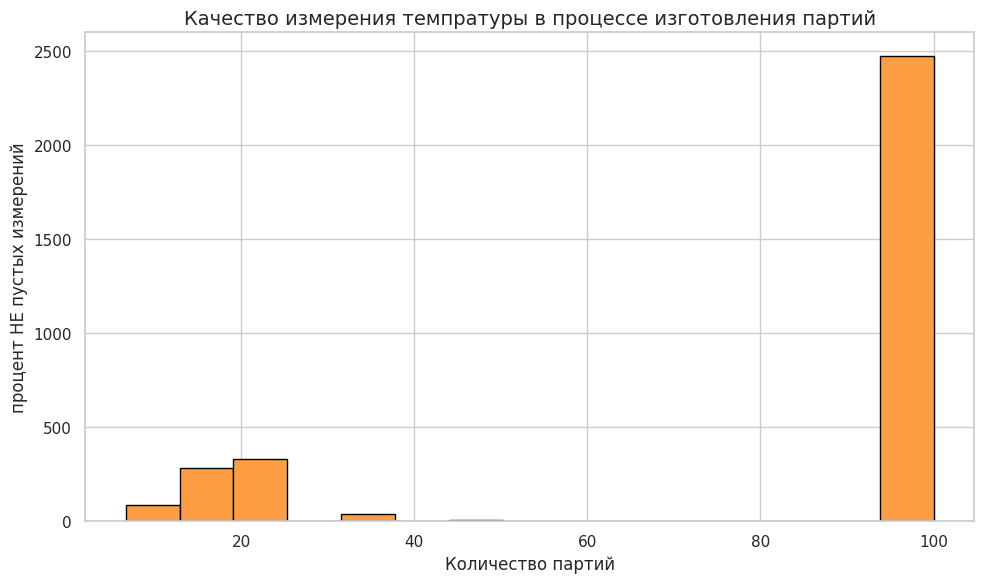

In [129]:
# изучим подробнее где пропуски
data_temp_agg = data_temp.groupby('key').count()
data_temp_agg['pct_nonempty'] = (data_temp_agg.temp/data_temp_agg.datetime)*100.

get_plot(
    data = data_temp_agg['pct_nonempty'],
    title='Качество измерения темпратуры в процессе изготовления партий',
    xlabel='Количество партий',
    ylabel = 'процент НЕ пустых измерений'
)

In [130]:
# Количество партий где есть хотбы одно отсутсвующие измерение температуры
len(data_temp_agg.query('pct_nonempty < 100'))

739

In [131]:
# оставляем только те партии, где полностью известы замеры температуры
data_temp = data_temp[data_temp.key.isin(data_temp_agg.query('pct_nonempty == 100').index.values)]

In [132]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13926 entries, 0 to 13925
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   key       13926 non-null  int64         
 1   datetime  13926 non-null  datetime64[ns]
 2   temp      13926 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 435.2 KB


### Выводы
Выполнили анализ и предобработку данных

data_arc

- переименовали колонки, привели данные к корректным типам
- Согласно максимальным и минимальным значениям признака arc_heating_start_dttm, у нас данные за 4 месяца.
- Также признак reactive_power имеет станадртное отклонение в разы больше чем у active_power, а все остальне метрики (медина, средние, 25%, 50%, 75%) отличаются не в разы. Возможно в данных есть выбросы.
- избавились отвыбросов путём их удаления

data_bulk и data_bulk_time

- проанализировали пропуски. Совпадение количества пропускорв говорит о том, что некоторые сыпучие материалы в партии не использовались. В тоже время мы можем предположить, что всегда при указании объёма сыпучего материала указывается время его добавления без пропусков.
- выполнили предобработку: Объединили объём и время добавления материала с идентефикатором материала, удалили малоиспользуемые, привели дату к корректному формату.
- Таким образом мы получили Entity-Attribute-Value структуру данных о подаче сыпучих материалов, которая не содержит пропусков и избавлена от малоиспользуемых материалов.

data_gas

- Данные о продувке газом не содержат привыязки ко времени. Судя по тому, что количество записей уникальным значением key равно количеству всех записей, можем сделать вывод о том, что продувка газом совершалась один раз в партии в неопределенный момент времени, указанным объёмом газа.

- Наиболее популярный объём газа в прартии от 9 до 10 единиц.

steel.data_wire и steel.data_wire_time

- Структура данных об использовании проволочных материалов очень похожа на данные о сыпучих материалов. Выполнили их предобработку схожим образом.
- Из графика видим, что есть проволочные материалы, который используются редко. Мы считаем, что от них необходимо избавиться для повышения качества модели.
- выполнили предобработку: Объединили объём и время добавления материала с идентефикатором материала, удалили малоиспользуемые, привели дату к корректному формату.
-Таким образом мы получили Entity-Attribute-Value структуру данных о подаче проволочных материалов, которая не содержит пропусков и избавлена от малоиспользуемых материалов.

data_temp

- переименовали колонки, привели типы данных к корректному формату
- мы оставили только те партии, в которых полдностью зивестны замеры температуры

### Рассмотрим путь одной партии

In [133]:
data_arc.query('key==1')

,key,arc_heating_start_dttm,arc_heating_end_dttm,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [134]:
data_bulk_eav.query('key==1')

,key,datetime,variable,value
0,1,2019-05-03 11:14:50,Bulk 14,150.0
0,1,2019-05-03 11:24:31,Bulk 12,206.0
0,1,2019-05-03 11:10:43,Bulk 15,154.0
0,1,2019-05-03 11:28:48,Bulk 4,43.0


In [135]:
data_gas.query('key==1')

,key,gas
0,1,29.749986


In [136]:
data_wire_eav.query('key==1')

,key,datetime,variable,value
0,1,2019-05-03 11:06:19,Wire 1,60.059998


In [137]:
data_temp.query('key==1')

,key,datetime,temp
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0


Напишем функцию синхпрнизации данных по одной партии с шагами процесса.
На выходе мы получим датафрейм, отражающий данные п о партии в производственной последовательности.

In [138]:
def build_timeline(key):
    #Начало нагрева
    data_arc_key_start = data_arc.query("key == @key")[['arc_heating_start_dttm', 'active_power']].reset_index()
    data_arc_key_start.columns = ['index', 'datetime', 'value']
    data_arc_key_start['event'] = data_arc_key_start['index'] \
        .apply(lambda x: 'arc_start_' + str(x))

    data_arc_key_start['event_desc'] = data_arc_key_start['index'] \
        .apply(lambda x: 'Начало нагрева дугой - итерация ' + str(x))


    #Конец нагрева
    data_arc_key_end = data_arc.query("key == @key")[['arc_heating_end_dttm', 'active_power']].reset_index()
    data_arc_key_end.columns = ['index', 'datetime', 'value']
    data_arc_key_end['event'] = data_arc_key_end['index'] \
        .apply(lambda x: 'arc_end_' + str(x))
    data_arc_key_end['event_desc'] = data_arc_key_end['index'] \
        .apply(lambda x: 'Конец нагрева дугой - итерация ' + str(x))

    #Подача сыпучих материалов
    data_bulk_key = data_bulk_eav.query("key == @key")
    data_bulk_key['event'] = data_bulk_key['variable']
    data_bulk_key['event_desc'] = data_bulk_key['variable'] \
        .apply(lambda x: 'Подача сыпучих материалов - ' + str(x))

    #Подача проволочных материалов
    data_wire_key = data_wire_eav.query("key == @key")
    data_wire_key['event'] = data_wire_key['variable']
    data_wire_key['event_desc'] = data_wire_key['variable'] \
        .apply(lambda x: 'Подача проволочных материалов - ' + str(x))

    #Газ
    #даныне без штампа времени

    #Температура
    data_temp_key = data_temp.query("key == @key").reset_index()
    data_temp_key.columns = ['index', 'key', 'datetime', 'value']
    data_temp_key['event'] = 'temp'
    data_temp_key['event'] = data_temp_key['index'] \
        .apply(lambda x: 'temp_' + str(x))
    data_temp_key['event_desc'] = data_temp_key['index'] \
        .apply(lambda x: 'Измерение тепературы - итерация ' + str(x))

    cols = ['datetime', 'event', 'value', 'event_desc']
    result = pd.concat([data_arc_key_start[cols],
               data_arc_key_end[cols],
               data_bulk_key[cols],
               data_wire_key[cols],
               data_temp_key[cols]])
    result['datetime'] = pd.to_datetime(result['datetime'])
    result = result.sort_values(by = 'datetime').reset_index(drop = True)
    return result

In [139]:
current_key_timeline = build_timeline(1)
current_key_timeline

,datetime,event,value,event_desc
0,2019-05-03 11:02:04,temp_0,1571.0,Измерение тепературы - итерация 0
1,2019-05-03 11:02:14,arc_start_0,0.30513,Начало нагрева дугой - итерация 0
2,2019-05-03 11:06:02,arc_end_0,0.30513,Конец нагрева дугой - итерация 0
3,2019-05-03 11:06:19,Wire 1,60.059998,Подача проволочных материалов - Wire 1
4,2019-05-03 11:07:18,temp_1,1604.0,Измерение тепературы - итерация 1
5,2019-05-03 11:07:28,arc_start_1,0.765658,Начало нагрева дугой - итерация 1
6,2019-05-03 11:10:33,arc_end_1,0.765658,Конец нагрева дугой - итерация 1
7,2019-05-03 11:10:43,Bulk 15,154.0,Подача сыпучих материалов - Bulk 15
8,2019-05-03 11:11:34,temp_2,1618.0,Измерение тепературы - итерация 2
9,2019-05-03 11:11:44,arc_start_2,0.580313,Начало нагрева дугой - итерация 2


## Создание признаков

Описанная хронология событий позволяет на взглянкть на весь процес в целом и выделить ряд новых признаков для предсказания температуры:
- Последняя предыдущая известная температура на момент текущего измерения
- Значение продувки газом при изготовлении партии
- Минут с начала производства партии до момента измерения температуры
- Количество итераций нагрева дугой до момента измерения температуры
- Суммарная работа нагрева на момент измерения температуры
- Серия столбцов - Данные о всех сессиях нагрева (активная мощность)
- Серия столбцов - Данные о всех сессиях нагрева (реактивная мощность)
- Серия столбцов - Данные о подаче сыпучих материалов с момента начала до момента измерения времени
- Серия столбцов - Данные о подаче проволочных материалов с момента начала до момента измерения времени

In [140]:
def calculate_total_power(key, temp_datetime):
    data_arc_key = data_arc.query("key == @key")
    data_arc_key = data_arc_key[data_arc_key['arc_heating_end_dttm'] < temp_datetime]
    data_arc_key['arc_diff'] = (data_arc_key['arc_heating_end_dttm'] - data_arc_key['arc_heating_start_dttm'])
    data_arc_key['arc_minures'] = data_arc_key['arc_diff'].apply(lambda x: x.total_seconds()/60)
    data_arc_key['active_power_x_minutes'] = data_arc_key['active_power'] * data_arc_key['arc_minures']


    total_active_power = data_arc_key['active_power_x_minutes'].sum()

    if isinstance(total_active_power, numbers.Number):
        return total_active_power
    else:
        return 0 #интерпретируем 0 как отсутстие мощности

def calculate_wire(key, wire_name, temp_datetime):
    wire_val = 0 #интерпретируем 0 как отсутстие подачи материалов

    wire_info = data_wire_eav[(data_wire_eav['key'] == key)
              & (data_wire_eav['datetime'] < temp_datetime)
             & (data_wire_eav['variable'] == wire_name)].reset_index()
    if len(wire_info) > 0:
        wire_val = wire_info.value[0]

    return wire_val


def calculate_bulk(key, bulk_name, temp_datetime):
    bulk_val = 0 #интерпретируем 0 как отсутстие подачи материалов

    bulk_info = data_bulk_eav[(data_bulk_eav['key'] == key)
              & (data_bulk_eav['datetime'] < temp_datetime)
             & (data_bulk_eav['variable'] == bulk_name)].reset_index()
    if len(bulk_info) > 0:
        bulk_val = bulk_info.value[0]

    return bulk_val

def calculate_last_known_temperature(key, temp_datetime):
    data_temp_key = data_temp[(
        data_temp['key'] == key)
        & (data_temp['datetime'] < temp_datetime)
        & ~(data_temp['temp'].isna())]
    data_temp_key = data_temp_key.sort_values(by = 'datetime')

    if len(data_temp_key) > 0:
        return data_temp_key.iloc[-1].temp
    else:
        return float('nan')

def calculate_arc_power_at_iteration(key, temp_datetime, iteration_num, feature_name):
    data_arc_key_finished = data_arc[(data_arc['key'] == key)
                                     & (data_arc['arc_heating_end_dttm'] < temp_datetime)] \
                            .sort_values(by = 'arc_heating_end_dttm').reset_index()
    if iteration_num < len(data_arc_key_finished):
        return data_arc_key_finished[feature_name][iteration_num]
    else:
        return 0 #интерпретируем 0 как отсутстие мощности

```calculate_total_power```

**Фильтрация данных:**

- Выбираются строки из data_arc, где key совпадает с переданным key и arc_heating_end_dttm меньше temp_datetime.
- Вычисление длительности нагрева:

- Создается новый столбец arc_diff, вычисляющий разницу между arc_heating_end_dttm и arc_heating_start_dttm.

**Перевод в минуты:**

- Длительность нагрева (arc_diff) переводится в минуты и сохраняется в новом столбце arc_minures.

**Вычисление активной мощности на минуты:**

- Создается столбец active_power_x_minutes, представляющий произведение active_power на arc_minures.

**Суммирование активной мощности:**

- Суммируются значения active_power_x_minutes для получения total_active_power.
Возврат результата:

- Проверяется, является ли total_active_power числом. Если да, возвращается это значение. Иначе, возвращается 0.

```calculate_wire```

**Инициализация:**

- Переменная wire_val устанавливается в 0.

**Фильтрация данных:**

- Отбираются строки из data_wire_eav, где:
- - key равен переданному значению,
- - datetime меньше temp_datetime,
- - variable равен wire_name.

**Получение значения:**

- Если есть хотя бы одна строка, wire_val устанавливается в первое значение столбца value.

**Возврат результата:**

- Возвращается wire_val.

```calculate_bulk```

**Инициализация:**

- Переменная bulk_val устанавливается в 0.

**Фильтрация данных:**

- Аналогично calculate_wire, фильтруются строки из data_bulk_eav.

**Получение значения:**

- Если найдена хотя бы одна строка, первое значение столбца value устанавливается в bulk_val.

**Возврат результата:**

- Возвращается bulk_val.

```calculate_last_known_temperature```

**Фильтрация данных:**

- Отбираются строки из data_temp, где:
- - key соответствует переданному значению,
- - datetime меньше temp_datetime,
- - temp не NaN.

**Сортировка по времени:**

- Данные сортируются по datetime.

**Возврат последней температурной записи:**

- Если есть данные, возвращается значение temp последней строки. Если данных нет, возвращается NaN.

```calculate_arc_power_at_iteration```

**Фильтрация и сортировка данных:**

- Из data_arc отбираются завершенные операции (на основе времени arc_heating_end_dttm) и строки сортируются по arc_heating_end_dttm.

**Выбор значения для итерации:**

- Если iteration_num меньше количества отфильтрованных записей, возвращается значение feature_name для данной итерации.

**Возврат результата:**

- Если итерация больше или равна количеству записей, возвращается 0.


In [141]:
#Полный список типов материалов, использованных на производстве после преобработки
wires_used = data_wire_eav.variable.value_counts().index.values
bulks_used = data_bulk_eav.variable.value_counts().index.values

# Возьмем только 8 итераций нагрева дугой (больше 8 бывает слишком редко)
max_arc_session_count = 8 # data_arc.groupby('key')['active_power'].count().max()

def create_features(key):
    key_tl = build_timeline(key)
    key_tl_min_dttm = key_tl.datetime.min()

    data_temp_key = data_temp.query("key == @key")

    #Последняя предыдущая известная температура на момент текущего измерения
    data_temp_key['key_last_known_temperature'] = data_temp_key['datetime'] \
        .apply(lambda dttm: calculate_last_known_temperature(key, dttm))

    #Значение продувки газом при изготовлении партии
    if len(data_gas.query("key == @key")['gas']) > 0:
        data_temp_key['key_gas_value'] = data_gas.query("key == @key")['gas'].values[0]

    #Минут с начала производства партии до момента измерения температуры
    data_temp_key['key_min_from_start'] = data_temp_key['datetime'] \
        .apply(lambda x: (x- key_tl_min_dttm).seconds/60)

    #Количество итераций нагрева дугой до момента измерения температуры
    data_temp_key['key_arc_cnt_from_start'] = data_temp_key['datetime'] \
        .apply(lambda x: len(key_tl[(key_tl['event'].str.contains("arc_end")) & (key_tl['datetime'] < x)])
    )
    #Суммарная работа нагрева на момент измерения температуры
    data_temp_key['key_total_arc_work_from_start'] = data_temp_key['datetime'] \
        .apply(lambda x: calculate_total_power(key, x))

    #Серия столбцов - Данные о всех сессиях нагрева (активная мощность)
    for it in range(max_arc_session_count):
        data_temp_key['key_arc_session_' + str(it) + '_from_start'] = data_temp_key['datetime'] \
            .apply(lambda dttm: calculate_arc_power_at_iteration(key, dttm, it, 'active_power'))

    #Серия столбцов - Данные о всех сессиях нагрева (реактивная мощность)
    for it in range(max_arc_session_count):
        data_temp_key['key_arc_react_session_' + str(it) + '_from_start'] = data_temp_key['datetime'] \
            .apply(lambda dttm: calculate_arc_power_at_iteration(key, dttm, it, 'reactive_power'))

    #Серия столбцов - Данные о подаче сыпучих материалов с момента начала до момента измерения времени
    for bulk in bulks_used:
        data_temp_key['key_' + str(bulk.replace(' ', '').lower()) + '_from_start'] = data_temp_key['datetime'] \
            .apply(lambda dttm: calculate_bulk(key, bulk, dttm))
    #Серия столбцов - Данные о подаче проволочных материалов с момента начала до момента измерения времени
    for wire in wires_used:
        data_temp_key['key_' + str(wire.replace(' ', '').lower()) + '_from_start'] = data_temp_key['datetime'] \
            .apply(lambda dttm: calculate_wire(key, wire, dttm))

    return data_temp_key



key_array = np.sort(data_temp.key.value_counts().index.values)
data_temp_arr = []
with ProcessPoolExecutor(max_workers=multiprocessing.cpu_count()) as executor:
    for r in tqdm(executor.map(create_features, key_array), total=len(key_array)):
        data_temp_arr.append(r)



data_temp_dm =  pd.concat(data_temp_arr, axis=0)
data_temp_dm

100%|██████████| 2477/2477 [12:48<00:00,  3.22it/s]


,key,datetime,temp,key_last_known_temperature,key_gas_value,key_min_from_start,key_arc_cnt_from_start,key_total_arc_work_from_start,key_arc_session_0_from_start,key_arc_session_1_from_start,key_arc_session_2_from_start,key_arc_session_3_from_start,...,key_arc_react_session_4_from_start,key_arc_react_session_5_from_start,key_arc_react_session_6_from_start,key_arc_react_session_7_from_start,key_bulk14_from_start,key_bulk12_from_start,key_bulk15_from_start,key_bulk3_from_start,key_bulk4_from_start,key_bulk6_from_start,key_wire1_from_start,key_wire2_from_start
0,1,2019-05-03 11:02:04,1571.0,NaN,29.749986,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0,0.000000,0
1,1,2019-05-03 11:07:18,1604.0,1571.0,29.749986,5.233333,1,1.159494,0.305130,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0,60.059998,0
2,1,2019-05-03 11:11:34,1618.0,1604.0,29.749986,9.500000,2,3.520273,0.305130,0.765658,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0,0,154.0,0.0,0.0,0,60.059998,0
3,1,2019-05-03 11:18:04,1601.0,1618.0,29.749986,16.000000,3,5.183837,0.305130,0.765658,0.580313,0.000000,...,0.0,0.0,0.0,0.0,150.0,0,154.0,0.0,0.0,0,60.059998,0
4,1,2019-05-03 11:25:59,1606.0,1601.0,29.749986,23.916667,4,8.338021,0.305130,0.765658,0.580313,0.518496,...,0.0,0.0,0.0,0.0,150.0,206.0,154.0,0.0,0.0,0,60.059998,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13921,2499,2019-08-10 13:33:21,1569.0,NaN,11.336151,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0,0.000000,0
13922,2499,2019-08-10 13:41:34,1604.0,1569.0,11.336151,8.216667,1,3.643520,0.700677,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0,0.000000,50.00528
13923,2499,2019-08-10 13:46:28,1593.0,1604.0,11.336151,13.116667,2,4.783922,0.700677,0.333776,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0,110.160958,50.00528
13924,2499,2019-08-10 13:54:56,1588.0,1593.0,11.336151,21.583333,3,6.781327,0.700677,0.333776,0.406252,0.000000,...,0.0,0.0,0.0,0.0,0,0,227.0,0.0,0.0,0,110.160958,50.00528


In [142]:
data_temp_dm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13926 entries, 0 to 13925
Data columns (total 32 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   key                                 13926 non-null  int64         
 1   datetime                            13926 non-null  datetime64[ns]
 2   temp                                13926 non-null  float64       
 3   key_last_known_temperature          11449 non-null  float64       
 4   key_gas_value                       13914 non-null  float64       
 5   key_min_from_start                  13926 non-null  float64       
 6   key_arc_cnt_from_start              13926 non-null  int64         
 7   key_total_arc_work_from_start       13926 non-null  float64       
 8   key_arc_session_0_from_start        13926 non-null  float64       
 9   key_arc_session_1_from_start        13926 non-null  float64       
 10  key_arc_session_2_from_star

Для первого измения партии нет предыдущего измерения, удалим строки в которых предыдущие значение пусто.

In [143]:
data_temp_dm_clean = data_temp_dm.dropna()

In [144]:
data_temp_dm_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11439 entries, 1 to 13925
Data columns (total 32 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   key                                 11439 non-null  int64         
 1   datetime                            11439 non-null  datetime64[ns]
 2   temp                                11439 non-null  float64       
 3   key_last_known_temperature          11439 non-null  float64       
 4   key_gas_value                       11439 non-null  float64       
 5   key_min_from_start                  11439 non-null  float64       
 6   key_arc_cnt_from_start              11439 non-null  int64         
 7   key_total_arc_work_from_start       11439 non-null  float64       
 8   key_arc_session_0_from_start        11439 non-null  float64       
 9   key_arc_session_1_from_start        11439 non-null  float64       
 10  key_arc_session_2_from_star

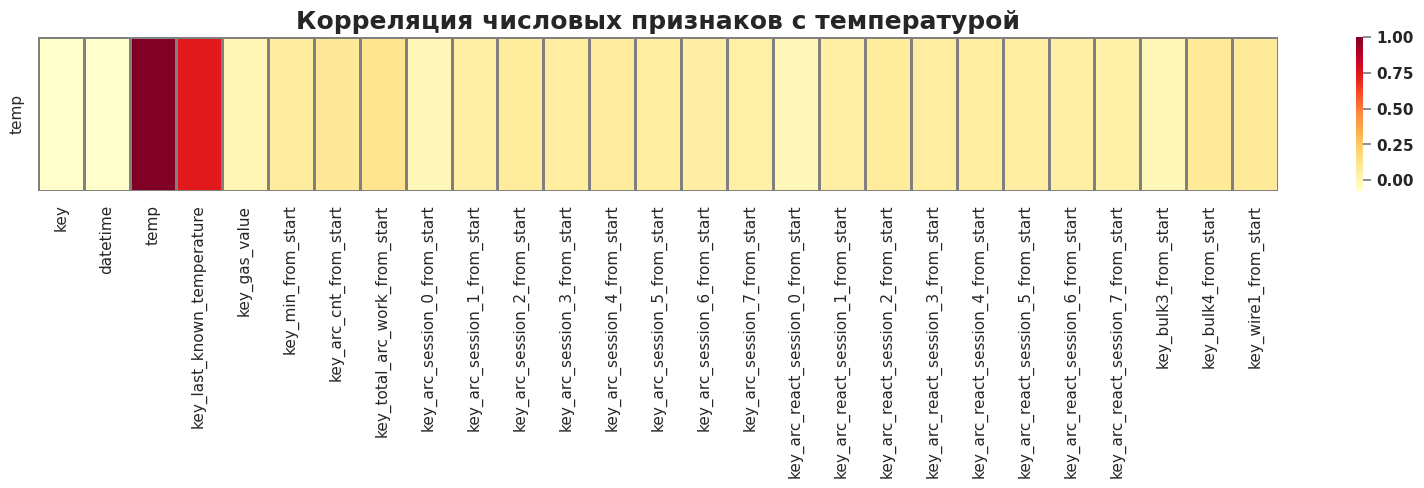

In [145]:
num = data_temp_dm_clean.select_dtypes(exclude='object')
numcorr = num.corr()

# Создать фигуру и оси
f, ax = plt.subplots(figsize=(20, 2))

# Построить тепловую карту с улучшениями
sns.heatmap(
    numcorr.sort_values(by=['temp'], ascending=False).head(1),
    cmap='YlOrRd',  # Изменяем палитру на теплую
    annot=False,     # Убрал аннотацию. Не помещается
    linewidths=1,   # Добавляем грани
    linecolor='gray'
)

# Установить заголовок
ax.set_title("Корреляция числовых признаков с температурой", weight='bold', fontsize=18)

# Разместить легенду с градиентом сбоку
cbar = ax.collections[0].colorbar
cbar.ax.yaxis.set_tick_params(color='gray')
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), weight='bold')
cbar.ax.yaxis.set_ticks_position('right')

# Показать график
plt.show()

### Выводы

Для начала построили хронологию движения одной партии. И на основе этого разработали новые признаки:

- Последняя предыдущая известная температура на момент текущего измерения
- Значение продувки газом при изготовлении партии
- Минут с начала производства партии до момента измерения температуры
- Количество итераций нагрева дугой до момента измерения температуры
- Суммарная работа нагрева на момент измерения температуры
- Серия столбцов - Данные о всех сессиях нагрева (активная мощность)
- Серия столбцов - Данные о всех сессиях нагрева (реактивная мощность)
- Серия столбцов - Данные о подаче сыпучих материалов с момента начала до момента измерения времени
- Серия столбцов - Данные о подаче проволочных материалов с момента начала до момента измерения времени

Предварительно изучили корреляцию признаков.
- Похоже, что Последняя предыдущая известная температура на момент текущего измерения сильно кррелирует с таргетом.

## Обучение моделей

### Выделение обучающей и тестовой выборки

Для каждой партии отнесем все измерения температуры, за исключением последнего, в обучающую выборку. Последнее измерение, в свою очередь, попадет в тестовую выборку. Таким образом, наша цель - предсказать последнее измерение температуры для каждой партии.

Важно отметить, что партии, у которых после очистки данных осталось только одно измерение температуры, исключаются из рассмотрения.

In [146]:
train_arr = []
test_arr = []

#Цикл по всем партиям
for key in tqdm(np.sort(data_temp.key.value_counts().index.values)):
    dm_key = data_temp_dm_clean.query("key == @key").sort_values(by = 'datetime')
    if len(dm_key) > 1:
        train_arr.append(dm_key.iloc[:-1])
        test_arr.append(dm_key.tail(1))

train_df = pd.concat(train_arr, axis=0)
test_df = pd.concat(test_arr, axis=0)

X_train = train_df.drop(['temp', 'datetime', 'key'], axis = 1)
X_test = test_df.drop(['temp', 'datetime', 'key'], axis = 1)
y_train = train_df.temp
y_test = test_df.temp

100%|██████████| 2477/2477 [00:11<00:00, 214.00it/s]


In [147]:
# выполним масштабирование признаков
scaler= StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [148]:
print('Размеры обучающей выборки', X_train.shape)
print('Размеры тестовой выборки', X_test.shape)

Размеры обучающей выборки (8966, 29)
Размеры тестовой выборки (2441, 29)


### Получение метрики константной модели

In [149]:
DummyModel_mean = DummyRegressor(strategy='mean')
DummyModel_median = DummyRegressor(strategy='median')

DummyModel_mean.fit(X_train, y_train)
dummy_mean_val_score = mean_absolute_error(y_test, DummyModel_mean.predict(X_test))

DummyModel_median.fit(X_train, y_train)
dummy_median_val_score = mean_absolute_error(y_test, DummyModel_median.predict(X_test))

print('MAE модели со стратегией среднего:', dummy_mean_val_score)
print('MAE модели со стратегией медианы:', dummy_median_val_score)

MAE модели со стратегией среднего: 10.29596519346655
MAE модели со стратегией медианы: 10.68701351904957


### Линейная регрессия

In [150]:
lreg=LinearRegression()
MSEs=ms.cross_val_score(lreg, X_train, y_train, scoring='neg_mean_absolute_error', cv=5)
meanMSE=np.mean(MSEs)
print('Средний MAE линейной регрессии на обучающей выборке с кросс-валидацией на 5 выборках: {:.2f}'.format(-meanMSE))

Средний MAE линейной регрессии на обучающей выборке с кросс-валидацией на 5 выборках: 8.00


In [151]:
lreg.fit(X_train, y_train)
lreg_test_pred = lreg.predict(X_test)
lreg_train_pred = lreg.predict(X_train)

print('MAE линейной регрессии на обучающей/тестовой выборке: {:.2f}/{:.2f}' \
      .format(mean_absolute_error(y_train, lreg_train_pred),
              mean_absolute_error(y_test, lreg_test_pred)))

MAE линейной регрессии на обучающей/тестовой выборке: 7.93/7.28


### Ридж регресси

Поищем оптимальные параметры регуляризации

In [152]:
ridge=Ridge()
parameters= {'alpha':[10**x for x in range(-4,4)]}

ridge_reg=ms.GridSearchCV(ridge, param_grid=parameters, scoring='neg_mean_absolute_error', cv=5)
ridge_reg.fit(X_train,y_train)
print('Лучший параметр alpha: ',ridge_reg.best_params_)
print('Наилучшая MAE: {:.2f}'.format(-ridge_reg.best_score_))

Лучший параметр alpha:  {'alpha': 10}
Наилучшая MAE: 8.00


In [153]:
ridge_mod=Ridge(alpha=10)
ridge_mod.fit(X_train,y_train)
y_pred_train=ridge_mod.predict(X_train)
y_pred_test=ridge_mod.predict(X_test)


print('MAE ридж регрессии на обучающей/тестовой выборке: {:.2f}/{:.2f}' \
      .format(mean_absolute_error(y_train, y_pred_train),
              mean_absolute_error(y_test, y_pred_test)))

MAE ридж регрессии на обучающей/тестовой выборке: 7.93/7.27


#### Выводы работы с линейными моделями

- линейные модели не позволяют достичь нужного результата

### Случайный лес

In [154]:
rfr=RandomForestRegressor(random_state=RND_ST)

param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8]
}

CV_rfr = ms.GridSearchCV(estimator=rfr,
                         param_grid=param_grid,
                         scoring='neg_mean_absolute_error',
                         cv= 5,
                         n_jobs = -1 #параллельный расчет на всех ядрах
                        )
CV_rfr.fit(X_train, y_train)


print("Наилучшие параметры: ",CV_rfr.best_params_)
print("Науилучшая MAE: ",(-CV_rfr.best_score_))

Наилучшие параметры:  {'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 200}
Науилучшая MAE:  8.462503196874735


In [155]:
# обучим модель с наилучшими параметрами
rfr_best=RandomForestRegressor(random_state=RND_ST, max_features='sqrt', n_estimators= 50, max_depth=8)
rfr_best.fit(X_train, y_train)

rfr_best_train=rfr_best.predict(X_train)
rfr_best_test=rfr_best.predict(X_test)

print('MAE случайного леса на обучающей/тестовой выборке: {:.2f}/{:.2f}' \
      .format(mean_absolute_error(y_train, rfr_best_train),
              mean_absolute_error(y_test, rfr_best_test)))

MAE случайного леса на обучающей/тестовой выборке: 7.88/7.00


### Модель CatBoostRegressor

In [156]:
def objective_CBR(trial, X_train=X_train, y_train=y_train.values, X_test=X_test, y_test=y_test.values):

    params = {'max_depth': trial.suggest_int('max_depth', 3, 3),                       # исследовал 3, 7
              'learning_rate': trial.suggest_float('learning_rate', 0.08768, 0.0877),  # исcледовал .001, .1
              'n_estimators': trial.suggest_int('n_estimators', 1125, 1127),           # исследовал 100, 1500
              'loss_function': 'MAE',
              'eval_metric': 'MAE'
             }

    model = CatBoostRegressor(**params, random_state=RND_ST)

    model.fit(X_train, y_train,
              eval_set=[(X_test, y_test)],
              early_stopping_rounds=100,
              verbose=False)

    return model.get_best_score()['validation']['MAE']

In [157]:
study_cbr = optuna.create_study(direction = 'minimize', study_name='CatBoost')
study_cbr.optimize(objective_CBR, n_trials = 20)

[I 2024-09-23 11:19:04,735] A new study created in memory with name: CatBoost
[I 2024-09-23 11:19:05,546] Trial 0 finished with value: 7.09115095825222 and parameters: {'max_depth': 3, 'learning_rate': 0.08769296013410625, 'n_estimators': 1127}. Best is trial 0 with value: 7.09115095825222.
[I 2024-09-23 11:19:06,167] Trial 1 finished with value: 7.0911430047619675 and parameters: {'max_depth': 3, 'learning_rate': 0.08768510394146384, 'n_estimators': 1126}. Best is trial 1 with value: 7.0911430047619675.
[I 2024-09-23 11:19:07,107] Trial 2 finished with value: 7.09114916654461 and parameters: {'max_depth': 3, 'learning_rate': 0.08769180739913036, 'n_estimators': 1125}. Best is trial 1 with value: 7.0911430047619675.
[I 2024-09-23 11:19:08,496] Trial 3 finished with value: 7.091149469276377 and parameters: {'max_depth': 3, 'learning_rate': 0.08769199851996476, 'n_estimators': 1127}. Best is trial 1 with value: 7.0911430047619675.
[I 2024-09-23 11:19:09,768] Trial 4 finished with value: 

In [201]:
best_params_cbr = study_cbr.best_params

In [225]:
study_cbr.best_trial.value

7.074344955846858

### Нейронные сети

In [160]:
class MyHyperModel(keras_tuner.HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        my_hyp_model = keras.Sequential()

        my_hyp_model.add(layers.Input(shape=(self.input_shape,), name='input'))

        # Выбор кол-ва слоев
        for i in range(hp.Int('num_layers', min_value=1, max_value=3, step=1)):

            # Выбор кол-ва нейронов для каждого из слоев
            my_hyp_model.add(
                layers.Dense(
                    units=hp.Int(f'units_{i}', min_value=2, max_value=128, step=1)
                )
            )
            my_hyp_model.add(layers.BatchNormalization())
            my_hyp_model.add(layers.ReLU())

            # Выбор Drop-out
            my_hyp_model.add(
                layers.Dropout(
                    rate=hp.Float(f'dp_{i}', min_value=0, max_value=0.5, step=0.05)
                )
            )

        my_hyp_model.add(layers.Dense(1, activation='relu', name='prediction'))

        # Выбор learning_rate
        learning_rate = hp.Float('lr', min_value=1e-3, max_value=1e-1, step=5e-3)
        my_hyp_model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
            loss=keras.losses.MeanSquaredError(),                           # функция потерь MSE
            metrics=[keras.metrics.MeanAbsoluteError()],                    # метрика MAE
        )
        return my_hyp_model

    def fit(self, hp, my_hyp_model, *args, **kwargs):
        return my_hyp_model.fit(
            *args,

            # Выбор размера батча
            batch_size=hp.Int('batch_size', min_value=8, max_value=64, step=2),
            **kwargs,
        )

In [161]:
my_hypermodel = MyHyperModel(X_train.shape[1])
hp = keras_tuner.HyperParameters()
my_hypermodel.build(hp)

tuner = keras_tuner.BayesianOptimization(
    hypermodel=my_hypermodel,
    hyperparameters=hp,
    objective=keras_tuner.Objective('val_mean_absolute_error', direction='min'),
    executions_per_trial=1,
    max_trials=50,
    overwrite=True,
    directory='keras_tuner',
    project_name='my_hyp_model',
    seed=RND_ST)

tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 128, 'step': 1, 'sampling': 'linear'}
dp_0 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': 'linear'}
lr (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.001, 'max_value': 0.1, 'step': 0.005, 'sampling': 'linear'}


In [162]:
X_train_tf = tf.constant(X_train)
y_train_tf = tf.constant(y_train)
X_test_tf = tf.constant(X_test)
y_test_tf = tf.constant(y_test)

print('Тензоры тренировочных данных:', X_train_tf.shape, y_train_tf.shape)
print('Тензоры трестовых данных:', X_test_tf.shape, y_test_tf.shape)

Тензоры тренировочных данных: (8966, 29) (8966,)
Тензоры трестовых данных: (2441, 29) (2441,)


In [163]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', min_delta=1e-2, patience=5)

tuner.search(X_train_tf, y_train_tf,
             validation_data=(X_test_tf, y_test_tf),
             epochs=1000,
             callbacks=[stop_early]
             )

Trial 50 Complete [00h 00m 16s]
val_mean_absolute_error: 9.966643333435059

Best val_mean_absolute_error So Far: 6.162301063537598
Total elapsed time: 00h 31m 56s


In [164]:
tuner.results_summary(1)

Results summary
Results in keras_tuner/my_hyp_model
Showing 1 best trials
Objective(name="val_mean_absolute_error", direction="min")

Trial 28 summary
Hyperparameters:
num_layers: 3
units_0: 62
dp_0: 0.15000000000000002
lr: 0.081
batch_size: 8
units_1: 94
dp_1: 0.35000000000000003
units_2: 38
dp_2: 0.0
Score: 6.162301063537598


In [165]:
MyNet = tuner.get_best_models()[0]
MyNet.build(input_shape=(None, X_train_tf.shape[1]))
MyNet.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 62)                  │           1,860 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 62)                  │             248 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 62)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 62)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 94)                  │           5,922 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 94)                  │             376 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 94)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 94)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 38)                  │           3,610 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 38)                  │             152 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 38)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 38)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ prediction (Dense)                   │ (None, 1)                   │              39 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,207 (47.68 KB)

 Trainable params: 11,819 (46.17 KB)

 Non-trainable params: 388 (1.52 KB)

In [166]:
net_val_score = mean_absolute_error(y_test_tf, MyNet.predict(X_test_tf))

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [167]:
net_val_score

6.162301707004046

### Нейронная сеть дала лучший результат: 6.35 на тестовой выборке.

## Сравнение результатов лучшей и константной модели

In [168]:
print('MAE константной модели со стратегией среднего:', dummy_mean_val_score)
print('MAE нейросети на тестовой выборке: ', net_val_score)

MAE константной модели со стратегией среднего: 10.29596519346655
MAE нейросети на тестовой выборке:  6.162301707004046


Подобное сравнение говорит о том, что результаты обучения модели показываент лучший результат, чем расчет простого среднего

### Вывод

Для каждой партии мы отнесли все измерения температуры, за исключением последнего, в обучающую выборку. Последнее измерение, в свою очередь, попадет в тестовую выборку. Таким образом, наша цель - предсказать последнее измерение температуры для каждой партии.

Важно отметить, что партии, у которых после очистки данных осталось только одно измерение температуры, исключаются из рассмотрения.

Выполнили масштабирование признаков

Получили метрики константной модели: MAE модели со стратегией среднего: 10.29596519346655

И приступили к обучению

- Линейная регрессия.
Средний MAE линейной регрессии на обучающей выборке с кросс-валидацией на 5 выборках: 8.00
MAE линейной регрессии на обучающей/тестовой выборке: 7.93/7.28

Не дотягивает до нужного результата

- Ридж регрессия.
MAE ридж регрессии на обучающей/тестовой выборке: 7.93/7.27

Тоже недостающий результат

- Случайный лес
MAE случайного леса на обучающей/тестовой выборке: 7.88/7.00

Также выше необходимого порога.

- Модель CatBoostRegressor. Лучший результат 7.07

- Нейронные сети
Удалось добиться Score: 6.16 на тестовой выборке.
Это результат ниже необходимого порога.

В сравнении лучшей и константной модели, побеждает модель основанная на нейросети:
MAE константной модели со стратегией среднего: 10.29596519346655
MAE нейросети на тестовой выборке:  6.162301707004046

## Исследование важности признаков

Мне не удалось вытащить данные о важности признаков из модели основанной на нейронной сети. Если ревьюер мне подскажет, как это можно сделать ,я буду благодарен и переделаю.

Чтобы приблизиться к пониманию вопроса, я исследовал возмоможности CatBoostRegressor в предоставлении информации о важности признаков.

In [196]:
def plot_feature_importance(importance, fch_names, model_type):

    feature_importance = np.array(importance)
    feature_names = np.array(fch_names)

    data={'feature_names': feature_names, 'feature_importance': feature_importance}
    fch_df = pd.DataFrame(data)
    fch_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(8,8))
    sns.barplot(x=fch_df['feature_importance'], y=fch_df['feature_names'])

    plt.title(model_type + ' Feature importance', fontsize=14)
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [216]:
CBRModel_best = CatBoostRegressor(**best_params_cbr)

In [217]:
CBRModel_best.fit(X_train, y_train,
          eval_set=[(X_test, y_test)],
          early_stopping_rounds=100,
          verbose=False)

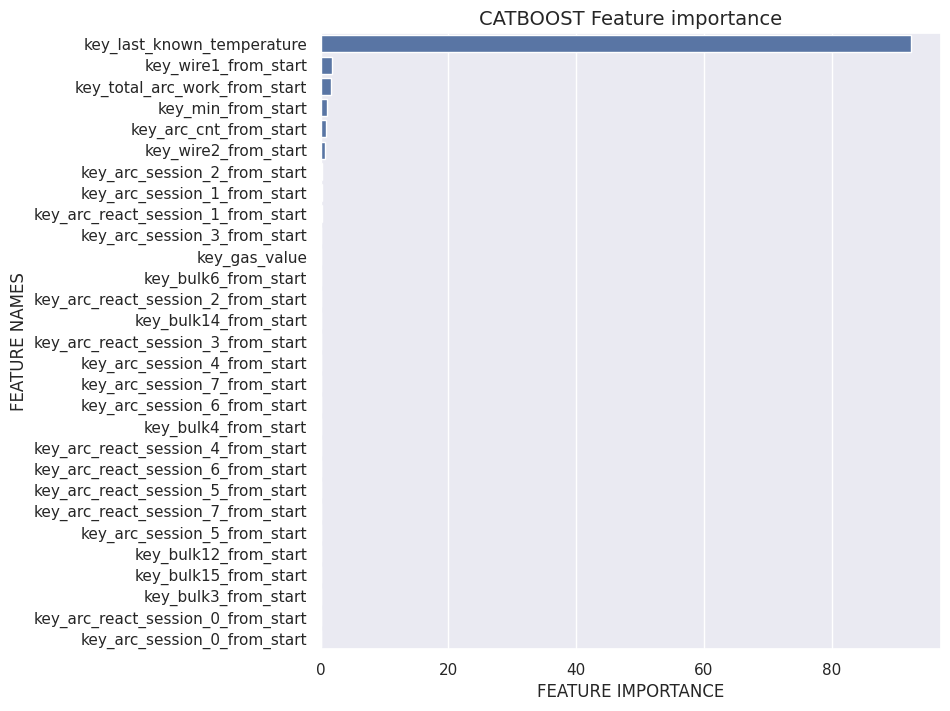

In [218]:
sns.set_theme(style='darkgrid')
plot_feature_importance(CBRModel_best.get_feature_importance(),
                        data_temp_dm.drop(['temp', 'datetime', 'key'], axis = 1).columns,'CATBOOST')

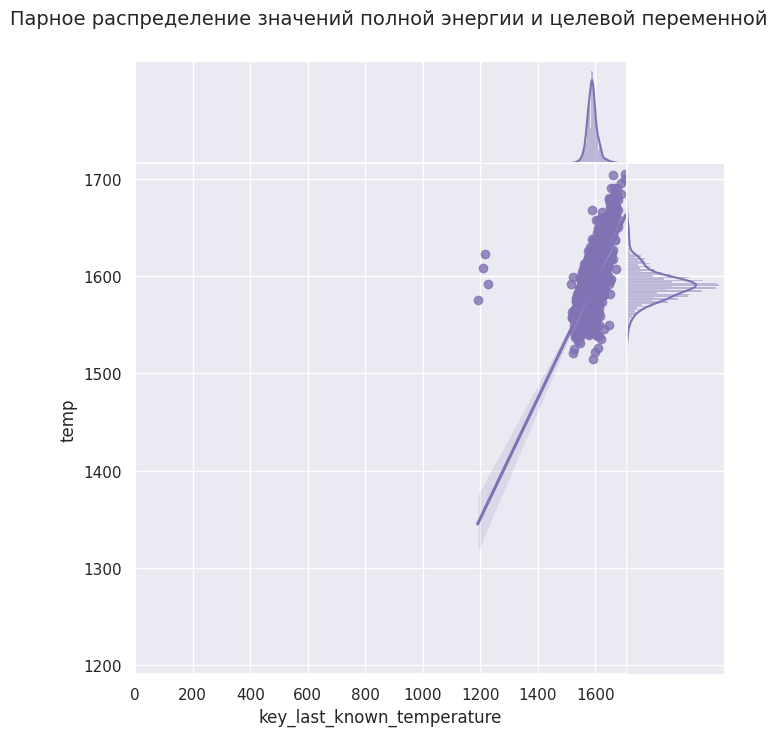

In [223]:
sns.jointplot(x=data_temp_dm['key_last_known_temperature'],
              y=data_temp_dm['temp'],
              height=7,
              ratio=5,
              space=0.01,
              xlim=[0, data_temp_dm['key_last_known_temperature'].max() +0.5],
              ylim=[data_temp_dm['temp'].min(), data_temp_dm['temp'].max() +10],
              kind='reg',
              color='m')
plt.suptitle('Парное распределение значений полной энергии и целевой переменной ',
             y = 1.05, fontsize = 14)
plt.show()

Как мы можем видеть из графиков признак key_last_known_temperature имеет прямую кореляцию с целевым признаком.

В ходе работы над проектом мы выполнили ряд работ:

**Подготовили окружение**

- загрузили библиотеки
- установили константы
- вспомогательные функции для построения графиков
- Настроили подключение к базе данных

**Выполнили исследовательский аналих данных**

Для начала выполнили общий анализ таблиц, убкдились в их наличии и в том ,что они содержат данные.

- мы написали функцию выполнения запроса к базе данных и сохранении запроса в датафрейм
- мы сделали запрос к sqlite_master для получения имён всех таблиц и сравнили результат с условием задачи. На основе этого мы смогли сделать вывод, что в базе таблиц больше чем в условии задачи, но при этом все таблицы из условия задачи в базе имеются
- мы запросили table_info к каждой таблице из базы даных и получили информацию о её полях. Полученный результат выведен в проект.
- мы запросили количество строк для каждой таблицы. На основе полученных данных мы делаем вывод о том, что все таблицы содержат данные.

**Выполнили крос анализх колонки кей**

- это дало нам понимание о том, сколько партий описаны в таблицах
- В каждой таблице разное количество уникалньных значений в поле key. Пересечений по ключам 3022 во всех таблицах.

**Выполнили анализ и предобработку данных**

data_arc

- переименовали колонки, привели данные к корректным типам
- Согласно максимальным и минимальным значениям признака arc_heating_start_dttm, у нас данные за 4 месяца.
- Также признак reactive_power имеет станадртное отклонение в разы больше чем у active_power, а все остальне метрики (медина, средние, 25%, 50%, 75%) отличаются не в разы. Возможно в данных есть выбросы.
- избавились отвыбросов путём их удаления

data_bulk и data_bulk_time

- проанализировали пропуски. Совпадение количества пропускорв говорит о том, что некоторые сыпучие материалы в партии не использовались. В тоже время мы можем предположить, что всегда при указании объёма сыпучего материала указывается время его добавления без пропусков.
- выполнили предобработку: Объединили объём и время добавления материала с идентефикатором материала, удалили малоиспользуемые, привели дату к корректному формату.
- Таким образом мы получили Entity-Attribute-Value структуру данных о подаче сыпучих материалов, которая не содержит пропусков и избавлена от малоиспользуемых материалов.

data_gas

- Данные о продувке газом не содержат привыязки ко времени. Судя по тому, что количество записей уникальным значением key равно количеству всех записей, можем сделать вывод о том, что продувка газом совершалась один раз в партии в неопределенный момент времени, указанным объёмом газа.

- Наиболее популярный объём газа в прартии от 9 до 10 единиц.

steel.data_wire и steel.data_wire_time

- Структура данных об использовании проволочных материалов очень похожа на данные о сыпучих материалов. Выполнили их предобработку схожим образом.
- Из графика видим, что есть проволочные материалы, который используются редко. Мы считаем, что от них необходимо избавиться для повышения качества модели.
- выполнили предобработку: Объединили объём и время добавления материала с идентефикатором материала, удалили малоиспользуемые, привели дату к корректному формату.
-Таким образом мы получили Entity-Attribute-Value структуру данных о подаче проволочных материалов, которая не содержит пропусков и избавлена от малоиспользуемых материалов.

data_temp

- переименовали колонки, привели типы данных к корректному формату
- мы оставили только те партии, в которых полдностью зивестны замеры температуры

**Выполнили создание признаков**

Для начала построили хронологию движения одной партии. И на основе этого разработали новые признаки:

- Последняя предыдущая известная температура на момент текущего измерения
- Значение продувки газом при изготовлении партии
- Минут с начала производства партии до момента измерения температуры
- Количество итераций нагрева дугой до момента измерения температуры
- Суммарная работа нагрева на момент измерения температуры
- Серия столбцов - Данные о всех сессиях нагрева (активная мощность)
- Серия столбцов - Данные о всех сессиях нагрева (реактивная мощность)
- Серия столбцов - Данные о подаче сыпучих материалов с момента начала до момента измерения времени
- Серия столбцов - Данные о подаче проволочных материалов с момента начала до момента измерения времени

Предварительно изучили корреляцию признаков.
- Похоже, что Последняя предыдущая известная температура на момент текущего измерения сильно кррелирует с таргетом.

**Выполнили обучение моделей**

Для каждой партии мы отнесли все измерения температуры, за исключением последнего, в обучающую выборку. Последнее измерение, в свою очередь, попадет в тестовую выборку. Таким образом, наша цель - предсказать последнее измерение температуры для каждой партии.

Важно отметить, что партии, у которых после очистки данных осталось только одно измерение температуры, исключаются из рассмотрения.

**Выполнили масштабирование признаков**

Получили метрики константной модели: MAE модели со стратегией среднего: 10.29596519346655

**И приступили к обучению**

- Линейная регрессия.
Средний MAE линейной регрессии на обучающей выборке с кросс-валидацией на 5 выборках: 8.00
MAE линейной регрессии на обучающей/тестовой выборке: 7.93/7.28

Не дотягивает до нужного результата

- Ридж регрессия.
MAE ридж регрессии на обучающей/тестовой выборке: 7.93/7.27

Тоже недостающий результат

- Случайный лес
MAE случайного леса на обучающей/тестовой выборке: 7.88/7.00

Также выше необходимого порога.

- Модель CatBoostRegressor. Лучший результат 7.07

- Нейронные сети
Удалось добиться Score: 6.16 на тестовой выборке.
Это результат ниже необходимого порога.

В сравнении лучшей и константной модели, побеждает модель основанная на нейросети:
MAE константной модели со стратегией среднего: 10.29596519346655
MAE нейросети на тестовой выборке:  6.162301707004046

**Исследование важности признаков показало, что*

- признак key_last_known_temperature имеет прямую кореляцию с целевым признаком.
